<a href="https://colab.research.google.com/github/lcmolteberg/Machineoblig3/blob/main/Assignment3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 3


# Exercise-1: Training Deep Neural Network on MNIST

In [1]:
!pip install pytorch-ignite

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 343.8/343.8 kB 8.9 MB/s eta 0:00:00


In [2]:
import sys

assert sys.version_info >= (3, 7)

In [3]:
from packaging import version
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, random_split
from torchvision import datasets, transforms
import numpy as np
import random
import matplotlib.pyplot as plt
from ignite.metrics import Accuracy, Loss, RunningAverage
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss, RunningAverage
from ignite.handlers import EarlyStopping
from copy import deepcopy

In [4]:
# Seed
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.cuda.manual_seed_all(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


In [5]:
# Dataset
tfm = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.1307,), std=(0.3081,))
])
train_set = datasets.MNIST("./data", train=True, transform=tfm, download=True)
test_set = datasets.MNIST("./data", train=False, transform=tfm, download=True)

# 1000 train and 200 test
n_train = 1000
n_test = 200

train_subset = Subset(train_set, np.arange(n_train))
test_subset = Subset(test_set, np.arange(n_test))

idx = train_subset.indices  # dette er np.arange(n_train)
print(len(idx), idx[:5], idx[-5:])

val_size = 200
train_size = n_train - val_size
train_subset, val_subset = random_split(
    train_subset, [train_size, val_size],
    generator=torch.Generator().manual_seed(seed)
)


batch_size = 32
train_loader = DataLoader(train_subset, batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size, shuffle=False)
test_loader = DataLoader(test_subset, batch_size)


100%|██████████| 9.91M/9.91M [00:00<00:00, 39.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.65MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 9.86MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 13.0MB/s]

1000 [0 1 2 3 4] [995 996 997 998 999]


In [6]:
# Model

class DNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.net = nn.Sequential(
            nn.Linear(28*28, 64),
            nn.ELU(),
            nn.Linear(64, 64),
            nn.ELU(),
            nn.Linear(64, 64),
            nn.ELU(),
            nn.Linear(64, 10)
        )
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        x = self.flatten(x)
        x = self.net(x)
        return x

model = DNN().to(device)


Epoch 01: Train 2.9424 | Val 0.8568
Epoch 02: Train 1.9906 | Val 0.6026
Epoch 03: Train 1.3151 | Val 0.5422
Epoch 04: Train 0.8638 | Val 0.5029
Epoch 05: Train 0.5643 | Val 0.5408
Epoch 06: Train 0.3660 | Val 0.5163
Epoch 07: Train 0.2369 | Val 0.5215
Epoch 08: Train 0.1534 | Val 0.5276


2025-11-03 10:37:22,717 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


Epoch 09: Train 0.0999 | Val 0.5326
Restored best weights (val_loss=0.5029)


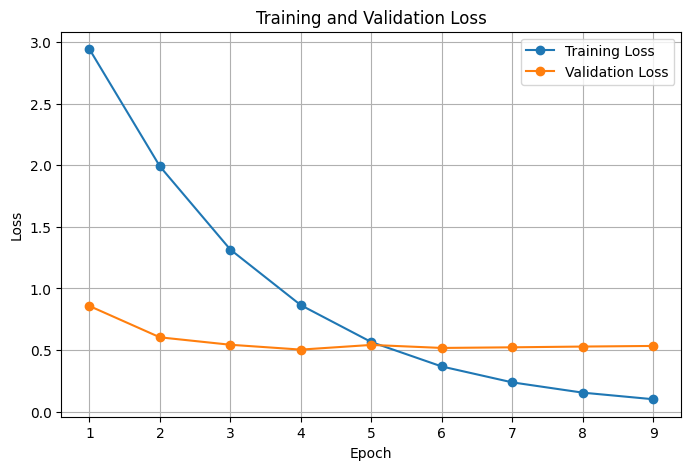

Test set — loss: 0.4179, accuracy: 0.8750
Final Test Accuracy: 87.50%


In [7]:
# Optimizer

optimizer = optim.NAdam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

best_state = {"best_val": float("inf"), "weights": None}


trainer = create_supervised_trainer(model, optimizer, loss_fn, device=device)
evaluator = create_supervised_evaluator(
    model, metrics={'accuracy': Accuracy(), 'loss': Loss(loss_fn)}, device=device
)

# --- enkel train-loss logging uten ekstra pass ---
RunningAverage(output_transform=lambda out: out).attach(trainer, "train_loss")

# --- EarlyStopping: høyere score = bedre, så returner -val_loss ---
def score_function(engine):
    return -engine.state.metrics['loss']

early_stop = EarlyStopping(patience=5, score_function=score_function, trainer=trainer)
# Viktig: kobles til EVALUATOR, og evaluator MÅ kjøres hver epoke
evaluator.add_event_handler(Events.COMPLETED, early_stop)

# --- historikk for plotting ---
train_losses, val_losses = [], []

@trainer.on(Events.EPOCH_COMPLETED)
def validate_and_log(engine):
    # Train loss fra RunningAverage ELLER beregn selv – beholder du din nåværende måte, bruk den
    train_loss = trainer.state.metrics['train_loss'] if 'train_loss' in trainer.state.metrics else None

    # Kjør validering (triggere EarlyStopping via evaluator-eventet)
    evaluator.run(val_loader)
    val_loss = evaluator.state.metrics['loss']

    # (valgfritt) hvis du ikke bruker RunningAverage: mål train loss med en egen evaluator-pass
    # evaluator.run(train_eval_loader); train_loss = evaluator.state.metrics['loss']

    train_losses.append(train_loss if train_loss is not None else float("nan"))
    val_losses.append(val_loss)

    # ---- SAVE BEST IN MEMORY (restore best weights) ----
    if val_loss < best_state["best_val"]:
        best_state["best_val"] = val_loss
        best_state["weights"] = deepcopy(model.state_dict())

    print(f"Epoch {engine.state.epoch:02d}: Train {train_loss:.4f} | Val {val_loss:.4f}")


# --- tren (ES kan stoppe før 50) ---
trainer.run(train_loader, max_epochs=50)
if best_state["weights"] is not None:
    model.load_state_dict(best_state["weights"])
    print(f"Restored best weights (val_loss={best_state['best_val']:.4f})")

# --- plot ---
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
epochs = range(1, len(train_losses)+1)
plt.plot(epochs, train_losses, marker='o', label='Training Loss')
plt.plot(epochs, val_losses,   marker='o', label='Validation Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Training and Validation Loss')
plt.legend(); plt.grid(True); plt.show()

# --- test ---
evaluator.run(test_loader)
m = evaluator.state.metrics
print(f"Test set — loss: {m['loss']:.4f}, accuracy: {m['accuracy']:.4f}")
print(f"Final Test Accuracy: {m['accuracy']*100:.2f}%")




# Exercise-2: Training Deep Neural Network on CIFAR-10


In [ ]:
# Dataset

cifar_mean = (0.4914, 0.4822, 0.4465)
cifar_std  = (0.2470, 0.2435, 0.2616)


tfm = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=cifar_mean, std=cifar_std)
])
train_set = datasets.CIFAR10("./data", train=True, transform=tfm, download=True)
test_set = datasets.CIFAR10("./data", train=False, transform=tfm, download=True)



# 1000 train and 200 test
n_train = 5000
n_test = 1000

train_subset = Subset(train_set, np.arange(n_train))
test_subset = Subset(test_set, np.arange(n_test))

idx = train_subset.indices  # dette er np.arange(n_train)
print(len(idx), idx[:5], idx[-5:])

val_size = 1000
train_size = n_train - val_size
train_subset, val_subset = random_split(
    train_subset, [train_size, val_size],
    generator=torch.Generator().manual_seed(seed)
)

batch_size = 128
train_loader = DataLoader(train_subset, batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size, shuffle=False)
test_loader = DataLoader(test_subset, batch_size)

5000 [0 1 2 3 4] [4995 4996 4997 4998 4999]


In [ ]:
# Model

class DNNCI(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.net = nn.Sequential(
            nn.Linear(32*32*3, 256),
            nn.ELU(),
            nn.Linear(256, 256),
            nn.ELU(),
            nn.Linear(256, 256),
            nn.ELU(),
            nn.Linear(256, 256),
            nn.ELU(),
            nn.Linear(256, 10)
        )
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        x = self.flatten(x)
        x = self.net(x)
        return x

modelCI = DNNCI().to(device)

Epoch 01: Train 2.9914 | Val 2.4663
Epoch 02: Train 2.3462 | Val 2.1172
Epoch 03: Train 1.8233 | Val 2.0777
Epoch 04: Train 1.4129 | Val 2.3732
Epoch 05: Train 1.0885 | Val 2.3639
Epoch 06: Train 0.8244 | Val 2.4312
Epoch 07: Train 0.6286 | Val 2.6047


2025-11-02 13:32:46,948 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


Epoch 08: Train 0.4739 | Val 2.6578
✅ Restored best weights (val_loss=2.0777)


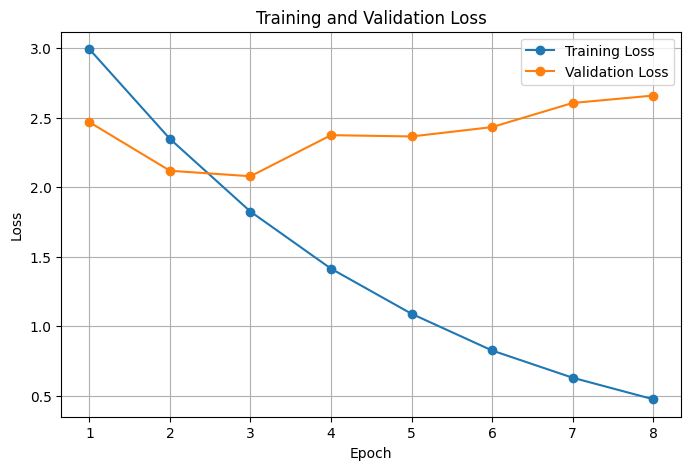

2025-11-02 13:32:47,424 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


Test set — loss: 2.1595, accuracy: 0.3300
Final Test Accuracy: 33.00%


In [ ]:
# Optimizer

optimizer = optim.NAdam(modelCI.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

best_state = {"best_val": float("inf"), "weights": None}


trainer = create_supervised_trainer(modelCI, optimizer, loss_fn, device=device)
evaluator = create_supervised_evaluator(
    modelCI, metrics={'accuracy': Accuracy(), 'loss': Loss(loss_fn)}, device=device
)

# --- enkel train-loss logging uten ekstra pass ---
RunningAverage(output_transform=lambda out: out).attach(trainer, "train_loss")

# --- EarlyStopping: høyere score = bedre, så returner -val_loss ---
def score_function(engine):
    return -engine.state.metrics['loss']

early_stop = EarlyStopping(patience=5, score_function=score_function, trainer=trainer)
# Viktig: kobles til EVALUATOR, og evaluator MÅ kjøres hver epoke
evaluator.add_event_handler(Events.COMPLETED, early_stop)

# --- historikk for plotting ---
train_losses, val_losses = [], []

@trainer.on(Events.EPOCH_COMPLETED)
def validate_and_log(engine):
    # Train loss fra RunningAverage ELLER beregn selv – beholder du din nåværende måte, bruk den
    train_loss = trainer.state.metrics['train_loss'] if 'train_loss' in trainer.state.metrics else None

    # Kjør validering (triggere EarlyStopping via evaluator-eventet)
    evaluator.run(val_loader)
    val_loss = evaluator.state.metrics['loss']

    # (valgfritt) hvis du ikke bruker RunningAverage: mål train loss med en egen evaluator-pass
    # evaluator.run(train_eval_loader); train_loss = evaluator.state.metrics['loss']

    train_losses.append(train_loss if train_loss is not None else float("nan"))
    val_losses.append(val_loss)

    # ---- SAVE BEST IN MEMORY (restore best weights) ----
    if val_loss < best_state["best_val"]:
        best_state["best_val"] = val_loss
        best_state["weights"] = deepcopy(modelCI.state_dict())

    print(f"Epoch {engine.state.epoch:02d}: Train {train_loss:.4f} | Val {val_loss:.4f}")


# --- tren (ES kan stoppe før 50) ---
trainer.run(train_loader, max_epochs=50)
if best_state["weights"] is not None:
    modelCI.load_state_dict(best_state["weights"])
    print(f"Restored best weights (val_loss={best_state['best_val']:.4f})")

# --- plot ---
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
epochs = range(1, len(train_losses)+1)
plt.plot(epochs, train_losses, marker='o', label='Training Loss')
plt.plot(epochs, val_losses,   marker='o', label='Validation Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Training and Validation Loss')
plt.legend(); plt.grid(True); plt.show()

# --- test ---
evaluator.run(test_loader)
m = evaluator.state.metrics
print(f"Test set — loss: {m['loss']:.4f}, accuracy: {m['accuracy']:.4f}")
print(f"Final Test Accuracy: {m['accuracy']*100:.2f}%")


# Exercise-3: Regularization with Alpha Dropout and MC Dropout

In [8]:
# Dataset
tfm = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.1307), std=(0.3081))
])

full_train = datasets.MNIST("./data", train=True, transform=tfm, download=True)
full_test = datasets.MNIST("./data", train=False, transform=tfm, download=True)

n_train = 1000
n_test = 200

train_subset = Subset(full_train, np.arange(n_train))
test_subset = Subset(full_test, np.arange(n_test))

val_size = 200
train_size = n_train - val_size
train_subset, val_subset = random_split(
    train_subset, [train_size, val_size],
    generator=torch.Generator().manual_seed(seed)
)

batch_size = 32
train_loader = DataLoader(train_subset, batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size, shuffle=False)
test_loader = DataLoader(test_subset, batch_size)



In [9]:
# Model

class DNN_ADMC(nn.Module):
  def __init__(self, p=0.1):
    super().__init__()
    self.flatten = nn.Flatten()
    self.net = nn.Sequential(
        nn.Linear(28*28, 64),
        nn.SELU(),
        nn.AlphaDropout(p),
        nn.Linear(64, 64),
        nn.SELU(),
        nn.AlphaDropout(p),
        nn.Linear(64, 64),
        nn.SELU(),
        nn.AlphaDropout(p),
        nn.Linear(64, 10)
    )
    self._lecun_init()

  def _lecun_init(self):
    for m in self.modules():
      if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, nonlinearity='linear')
        if m.bias is not None:
          nn.init.zeros_(m.bias)

  def forward(self, x):
    return self.net(self.flatten(x))

model_ADMC = DNN_ADMC().to(device)


Epoch 01: Train 0.0064 | Val 1.3333
Epoch 02: Train 0.0094 | Val 1.5548
Epoch 03: Train 0.0109 | Val 1.3429
Epoch 04: Train 0.0141 | Val 1.3040
Epoch 05: Train 0.0152 | Val 1.2561
Epoch 06: Train 0.0184 | Val 1.3462
Epoch 07: Train 0.0185 | Val 1.4076
Epoch 08: Train 0.0298 | Val 1.4890
Epoch 09: Train 0.0305 | Val 1.4315
Epoch 10: Train 0.0275 | Val 1.5953
Epoch 11: Train 0.0253 | Val 1.5202
Epoch 12: Train 0.0221 | Val 1.4837
Epoch 13: Train 0.0189 | Val 1.4749
Epoch 14: Train 0.0231 | Val 1.6146
Epoch 15: Train 0.0238 | Val 1.6622
Epoch 16: Train 0.0264 | Val 1.7014
Epoch 17: Train 0.0279 | Val 1.5880
Epoch 18: Train 0.0264 | Val 1.6448
Epoch 19: Train 0.0189 | Val 1.6506
Epoch 20: Train 0.0156 | Val 1.6219
Epoch 21: Train 0.0217 | Val 1.6086
Epoch 22: Train 0.0225 | Val 1.6419
Epoch 23: Train 0.0208 | Val 1.9080
Epoch 24: Train 0.0169 | Val 1.6256
Epoch 25: Train 0.0121 | Val 1.8272
Epoch 26: Train 0.0135 | Val 1.6975
Epoch 27: Train 0.0139 | Val 1.6492
Epoch 28: Train 0.0119 | Val

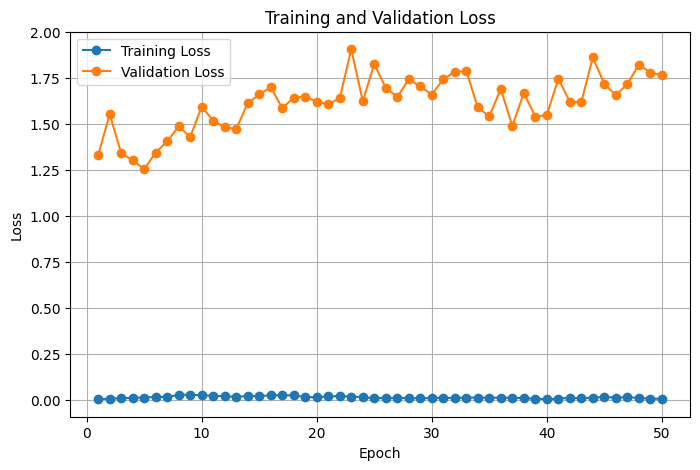

Test set — loss: 0.6984, accuracy: 0.9000
Final Test Accuracy: 90.00%


In [11]:
# Optimizer

optimizer = optim.NAdam(model_ADMC.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

trainer = create_supervised_trainer(model_ADMC, optimizer, loss_fn, device=device)
evaluator = create_supervised_evaluator(
    model_ADMC, metrics={'accuracy': Accuracy(), 'loss': Loss(loss_fn)}, device=device
)

RunningAverage(output_transform=lambda out: out).attach(trainer, "train_loss")

train_losses, val_losses = [], []

@trainer.on(Events.EPOCH_COMPLETED)
def log_epoch(engine):
    train_loss = trainer.state.metrics['train_loss'] if 'train_loss' in trainer.state.metrics else None
    evaluator.run(val_loader)
    val_loss = evaluator.state.metrics['loss']
    train_losses.append(train_loss if train_loss is not None else float("nan"))
    val_losses.append(val_loss)
    print(f"Epoch {engine.state.epoch:02d}: Train {train_loss:.4f} | Val {val_loss:.4f}")

trainer.run(train_loader, max_epochs=50)

plt.figure(figsize=(8,5))
epochs = range(1, len(train_losses)+1)
plt.plot(epochs, train_losses, marker='o', label='Training Loss')
plt.plot(epochs, val_losses,   marker='o', label='Validation Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Training and Validation Loss')
plt.legend(); plt.grid(True); plt.show()



In [ ]:
# Test
evaluator.run(test_loader)
m = evaluator.state.metrics
print(f"Test set — loss: {m['loss']:.4f}, accuracy: {m['accuracy']:.4f}")
print(f"Final Test Accuracy: {m['accuracy']*100:.2f}%")